## Assignment-2 AutoML
**AUTHOR: AKHILESH DONGRE**

**NU ID:  002784651**


Implementation of AutoML: Automated machine learning, also referred to as automated ML or AutoML, is the process of automating the time-consuming, iterative tasks of machine learning model development. It allows data scientists, analysts, and developers to build ML models with high scale, efficiency, and productivity all while sustaining model quality.

Implementing AutoML using H2O: H2O is a fully open-source, distributed in-memory machine learning platform with linear scalability. H2O supports the most widely used statistical & machine learning algorithms, including gradient boosted machines, generalized linear models, deep learning, and many more.


### Abstract: 

Problem Statement: Using H2O AutoML to train a model that will help us predict car prices. The dataset we will be working with contains information on various cars. The main aim of this project is to predict the price of used cars based on various features.

We Will be using Generalized Linear Model (GLM) in H2O automl to be able to operate on hyperparameters to control regularization in L1(Lasso) and L2 (Ridge) by modifying alpha and lambda. Also, Choosing appropriate family to train the model.

Assumptions for GLM model:

linearity The relationship between the variables can be described by a linear equation (also called additivity)

independence The residuals are independent of each other

equal variance The residuals have equal variance (also called homoskedasticity)

normality The distribution of the residuals is normal



The Features used for prediction:
* Location: Categorical, The place  in which the car is being sold or is available for purchase.
*  Year:numeric, The make year of the car.
*  Kilometers_Driven: numeric, Amount of distance covered by the car in KM.
*  Fuel_Type: Categorical,The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG) (Used for Multiclass Classification) 
* Transmission: Categorical, Transmission can be automatic or manual. (Used for Binary Classification) 
* Owner_Type:Categorical, Whether its first hand, second hand... Fourth hand.
* Mileage:numeric,The standard mileage offered by the car company in kmpl . 
* Engine: numeric,The displacement volume of the engine in CC.
* Power: numeric,The maximum power of the engine in bhp.
* Seats: numeric,The number of seats in the car.
* Price: numeric, The price of a new car of the same model.(lacs)(Regression)





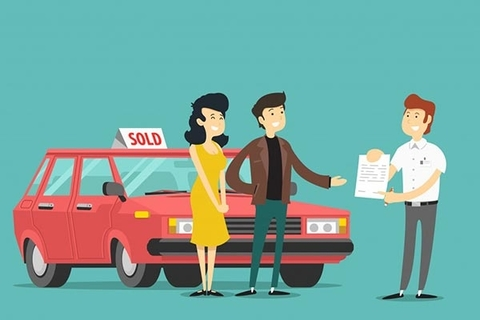

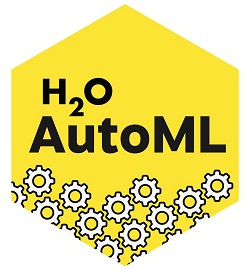

Images taken from: 
[H2O Image](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/h2o-automl-logo.jpg)
[Car Image](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.kaggle.com%2Fankits29%2Fused-car-price-prediction-all-ml-models&psig=AOvVaw0FGBEBap4xYL0mM7SnsmUl&ust=1667961887868000&source=images&cd=vfe&ved=0CAwQjRxqFwoTCMin0LDInfsCFQAAAAAdAAAAABAT)

In [226]:
! pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [227]:
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import re
import matplotlib.pylab as plt
import numpy as np
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 57 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_g0mjdc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.949 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [228]:
car_csv = "/content/car_data.csv"  # modify this for your machine
data=pd.read_csv("/content/car_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [229]:
#Removing nulls and columns which are not useful
data.drop(columns=["Unnamed: 0","New_Price","Name"],inplace=True)
print(data.columns[data.isna().any()])
data=data.dropna()

Index(['Mileage', 'Engine', 'Power', 'Seats'], dtype='object')


##Data Preprocessing 

In [230]:
data['Mileage'] = data['Mileage'].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))
data['Engine'] = data['Engine'].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))
data['Power'] = data['Power'].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))

data['Mileage'] = pd.to_numeric(data['Mileage'])
data['Engine'] = pd.to_numeric(data['Engine'])
data['Power'] = pd.to_numeric(data['Power'])
data=data.dropna()

data_pd=data.copy()

data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


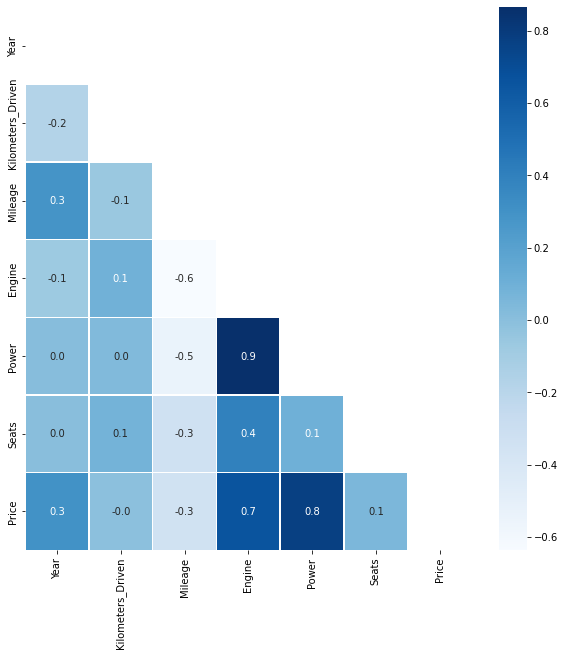

In [233]:
import seaborn as sns
f,ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(data_pd.corr().corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_pd.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
plt.show() 

Looking at the above correlation Heatmap, the inferences are:
1. Engine is highly correlated to the Price and Power.
2. Power is highly correlated to Price. 
3. Mileage is inversely correlated to power.
4. As we know that engine would also depend on the fuel type and transmission so we must assume that the independent features will be highly correlated while prediction. 


In [234]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = data_pd.drop(columns={"Location","Fuel_Type","Owner_Type","Transmission"})
# df_vif.drop(columns={'song_popularity','song_name'}, inplace = True)

X = df_vif.loc[:,df_vif.columns != 'Price']
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] =X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature         VIF
0               Year  127.552438
1  Kilometers_Driven    1.425195
2            Mileage   31.865500
3             Engine   60.079233
4              Power   30.846298
5              Seats   75.034589


Looking at the above Variance Inflation Factor, wrt Price the inferences are:

Year is highly multi-colinear followed by Seats, Engine, Mileage, Power
There is high multicolinearity in the data set.
Kilometers_Driven is not multi-collinear.

In [235]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = data_pd.drop(columns={"Location","Fuel_Type","Owner_Type"})
# df_vif.drop(columns={'song_popularity','song_name'}, inplace = True)

X = df_vif.loc[:,df_vif.columns != 'Transmission']
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] =X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = data_pd.drop(columns={"Location","Transmission","Owner_Type"})
# df_vif.drop(columns={'song_popularity','song_name'}, inplace = True)

X = df_vif.loc[:,df_vif.columns != 'Fuel_Type']
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] =X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

             feature         VIF
0               Year  132.041745
1  Kilometers_Driven    1.428904
2            Mileage   32.424659
3             Engine   60.116665
4              Power   39.546935
5              Seats   75.038461
6              Price    4.380338
             feature         VIF
0               Year  132.041745
1  Kilometers_Driven    1.428904
2            Mileage   32.424659
3             Engine   60.116665
4              Power   39.546935
5              Seats   75.038461
6              Price    4.380338


Looking at the above Variance Inflation Factor, wrt Transmission, Fuel Type the inferences are:

Year is highly multi-colinear followed by Seats, Engine, Mileage, Power
There is high multicolinearity in the data set.

Price and Kilometers_Driven are not multi-collinear.

## Binary Classification using AutoML h2o

In [236]:
def get_variables_types(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    

In [237]:
from re import X
target = 'Transmission'
x=get_variables_types(data, target) 
y=target

print(x)

['Year', 'Kilometers_Driven', 'Engine', 'Seats', 'Location', 'Fuel_Type', 'Owner_Type', 'Mileage', 'Power', 'Price']


In [238]:
import statsmodels.formula.api as statsmodel
data_pd['Transmission'] = data_pd['Transmission'].map({'Automatic': 0,'Manual': 1})
var = statsmodel.logit(formula="Transmission ~ C(Location) + Year + Kilometers_Driven + C(Fuel_Type) + C(Owner_Type) + Mileage + Engine + Power + Seats +Price", data=data_pd).fit()
var.summary()

         Current function value: 0.287893
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Transmission   No. Observations:                 5872
Model:                          Logit   Df Residuals:                     5848
Method:                           MLE   Df Model:                           23
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                  0.5218
Time:                        02:34:36   Log-Likelihood:                -1690.5
converged:                      False   LL-Null:                       -3535.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -32.4122   2900.965     -0.011      0.991   -5718.199    5653.375
C(Location)[T.Bangalore]           -0.0572      0.297     -0.193      0.847      -0.639       0.525
C(Location)[T.Chennai]             -0.2544      0.285     -0.894      0.371      -0.812       0.303
C(Location)[T.Coimbatore]           0.0162      0.273      0.059      0.953      -0.519       0.552
C(Location)[T.Delhi]               -0.1481      0.274     -0.541      0.588      -0.685       0.388
C(Location)[T.Hyderabad]           -0.1594      0.274     -0.582      0.561      -0.696       0.378
C(Location)[T.Jaipur]               0.2891      0.311      0.931      0.352      -0.320       0.898
C(Location)[T.Kochi]               -0.0018      0.272     -0.007      0.995      -0.534       0.531
C(Location)[T.Kolkata]              0.3531      0.297      1.189      0.234      -0.229       0.935
C(Location)[T.Mumbai]              -0.5120      0.259     -1.975      0.048      -1.020      -0.004
C(Location)[T.Pune]                -0.2690      0.273     -0.986      0.324      -0.804       0.266
C(Fuel_Type)[T.Diesel]            -16.5042   2900.602     -0.006      0.995   -5701.580    5668.571
C(Fuel_Type)[T.LPG]                 3.1915   4.08e+04   7.83e-05      1.000   -7.99e+04    7.99e+04
C(Fuel_Type)[T.Petrol]            -17.2493   2900.602     -0.006      0.995   -5702.325    5667.826
C(Owner_Type)[T.Fourth & Above]    -0.1023      1.557     -0.066      0.948      -3.155       2.950
C(Owner_Type)[T.Second]            -0.0781      0.131     -0.595      0.552      -0.336       0.179
C(Owner_Type)[T.Third]             -0.1910      0.345     -0.554      0.579      -0.867       0.484
Year                                0.0241      0.023      1.052      0.293      -0.021       0.069
Kilometers_Driven                1.835e-06   6.63e-07      2.768      0.006    5.35e-07    3.13e-06
Mileage                             0.0479      0.021      2.231      0.026       0.006       0.090
Engine                              0.0003      0.000      1.038      0.299      -0.000       0.001
Power                              -0.0310      0.003    -11.174      0.000      -0.036      -0.026
Seats                               1.1217      0.102     11.049      0.000       0.923       1.321
Price                              -0.2080      0.017    -12.506      0.000      -0.241      -0.175
===================================================================================================
"""

For Binary Classification of transmission the following are significant variables as its P(Z) value is less than 0.05:

* Kilometers_Driven
* Seats 
* Power
* Mileage
* Price
* Location- Mumbai

In [239]:
classifcation = True
balance_y=False
df=h2o.deep_copy(data, 'df')
balance_threshold=0.20
if classifcation:
    class_percentage = y_balance=df[y].mean()[0]/(df[y].max()-df[y].min())
    if class_percentage < balance_threshold:
        balance_y=True

print(balance_y)


False


In [240]:

data[y] = data[y].asfactor()
print(data[y].levels())

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

print ("Rows in Train",train.nrow)
print ("Rows in Validation",valid.nrow)
print ("Rows in Test",test.nrow)

[['Automatic', 'Manual']]
Rows in Train 4124
Rows in Validation 861
Rows in Test 887


In [241]:
aml = H2OAutoML(max_models =10,max_runtime_secs_per_model=30,exclude_algos=['DeepLearning','DRF'],
                balance_classes=True,	seed =1)
aml.train(training_frame = train,
          y = y)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_6_20221108_23437,0.97924,0.161659,0.991099,0.079212,0.215278,0.0463447
StackedEnsemble_BestOfFamily_1_AutoML_6_20221108_23437,0.979126,0.162117,0.991027,0.080829,0.21523,0.046324
GBM_5_AutoML_6_20221108_23437,0.978472,0.172677,0.990762,0.0866978,0.22385,0.0501088
GBM_3_AutoML_6_20221108_23437,0.977448,0.17909,0.990486,0.0826064,0.228133,0.0520446
XGBoost_3_AutoML_6_20221108_23437,0.976371,0.176969,0.989711,0.0809825,0.224419,0.0503638
GBM_2_AutoML_6_20221108_23437,0.975504,0.18146,0.989336,0.0863447,0.229255,0.0525579
GBM_4_AutoML_6_20221108_23437,0.974624,0.188273,0.988772,0.0907683,0.234264,0.0548794
XGBoost_grid_1_AutoML_6_20221108_23437_model_1,0.973372,0.181683,0.988393,0.0851413,0.230657,0.0532027
GBM_1_AutoML_6_20221108_23437,0.969969,0.197315,0.987108,0.101133,0.24285,0.0589762
XGBoost_2_AutoML_6_20221108_23437,0.968415,0.206864,0.985929,0.105387,0.245485,0.060263


In [242]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_6_20221108_23437

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.010672300256029542
RMSE: 0.10330682579592475
LogLoss: 0.056950074221652956
AUC: 0.9996348267936753
AUCPR: 0.9998605466682069
Gini: 0.9992696535873506
Null degrees of freedom: 4123
Residual degrees of freedom: 4120
Null deviance: 4930.332599042776
Residual deviance: 469.72421218019355
AIC: 477.72421218019355

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4745915619880026
           Automatic    Manual    Error    Rate
---------  -----------  --------  -------  -------------
Automatic  1163         13        0.0111   (13.0/1176.0)
Manual     12           2936      0.0041   (12.0/2948.0)
Total      1175         2949      0.0061   (25.0/4124.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    valu

In [243]:
# automl
# runs for run_time seconds then builds a stacked ensemble
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
#setting alpha=0, lambda_=0 means no selection of regularization

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1',alpha=0,lambda_= 0, standardize=True)

glm_fit1.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips( on=False)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [244]:
#setting labda_search=True for means optimum regularization using L1 and L2 methods
glm_fit2 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit2', lambda_search=True, standardize=True)
glm_fit2.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [245]:
# Comparing both results on validation set
glm_perf1 = glm_fit1.model_performance(valid)
glm_perf2 = glm_fit2.model_performance(valid)

# Print model performance
print (glm_perf1.confusion_matrix(),glm_perf1.accuracy())
print (glm_perf2.confusion_matrix(),glm_perf2.accuracy())

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4013825533365878
           Automatic    Manual    Error    Rate
---------  -----------  --------  -------  ------------
Automatic  176          76        0.3016   (76.0/252.0)
Manual     14           595       0.023    (14.0/609.0)
Total      190          671       0.1045   (90.0/861.0) [[0.5265911351288859, 0.8954703832752613]]
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3996939978218974
           Automatic    Manual    Error    Rate
---------  -----------  --------  -------  ------------
Automatic  177          75        0.2976   (75.0/252.0)
Manual     13           596       0.0213   (13.0/609.0)
Total      190          671       0.1022   (88.0/861.0) [[0.3996939978218974, 0.8977932636469221]]


In [246]:
# Retreive test set AUC
print (glm_perf1.auc())
print (glm_perf2.auc())

0.9166145385357207
0.9205013422993719


On comparing two glm models the conclusions are:
When using Regularization the model(glm_perf2) is performing somewhat worse when compared to the one with no regularization(glm_perf1) wrt the accuracy as glm_perf2 avoids overfitting of the model due to regularization.

On Similar grounds we can also see the AUC for model(glm_perf2) with regularization is better meaning it can handle predictions better than model with no regularization(glm_perf1).

In [247]:
varimp = glm_fit2.varimp(use_pandas=True)
varimp.head(10)

,variable,relative_importance,scaled_importance,percentage
0,Price,2.328282,1.000000,0.259209
1,Power,1.511286,0.649099,0.168252
2,Seats,0.948221,0.407262,0.105566
3,Fuel_Type.Petrol,0.773215,0.332097,0.086082
4,Location.Jaipur,0.686065,0.294666,0.076380
5,Fuel_Type.CNG,0.448789,0.192756,0.049964
6,Location.Mumbai,0.333376,0.143185,0.037115
7,Location.Pune,0.289086,0.124163,0.032184
8,Location.Kolkata,0.265336,0.113962,0.029540
9,Mileage,0.221401,0.095092,0.024649


In [248]:
pred = glm_fit2.predict(valid)
pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,Automatic,Manual
Manual,0.1543,0.8457
Automatic,0.816496,0.183504
Manual,0.00941193,0.990588
Manual,0.295532,0.704468
Manual,0.0173074,0.982693
Manual,0.109771,0.890229
Manual,0.0232643,0.976736
Manual,0.0224835,0.977517
Manual,0.159337,0.840663
Manual,0.488148,0.511852


### ANSWERS FOR BINARY CLASSIFICATION

* Is the relationship significant?
    
    Yes Signiicant relations between Transmission and the following variables are seen using P(Z) < 0.05 :

  * Kilometers_Driven
  * Seats 
  * Power
  * Mileage
  * Price
  * Location- Mumbai 

    Looking at the above correlation Heatmap, the inferences are:

    Engine is highly correlated to the Price and Power.
    Power is highly correlated to Price.
    As we know that engine would also depend on the fuel type and transmission so we must assume that the independent features will be highly correlated while prediction.


* Are any model assumptions violated?
 
 No, All conditions are satisfied.
  Binomial Classification Assumptions:

  Excerpts from Documentation:

  If you DO convert the response column to categorical and DO NOT to set family=binomial, then you will receive an error message.

  If you DO NOT convert response column to categorical and DO NOT set the family, then GLM will assume the 0s and 1s are numbers and will provide a Gaussian solution to a regression problem.

 



* Is there any multicollinearity in the model?

  Yes,  As Observed in the Correlation Heatmap and VIF.
  Year is highly multi-colinear followed by Seats, Engine, Mileage, Power
There is high multicolinearity in the data set.
Kilometers_Driven is not multi-collinear.
* In the multivariate models are predictor variables independent of all the other predictor variables?

    No, As Observed in the Correlation Heatmap and VIF method, high collinearity exists between the independent variables.


* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.
  
  Top 5 significant variables:

  1 Price

  2 Power

  3 Seats 

  4 Fuel_type.Petrol

  5 Location.Jaipur	


* Does the model make sense?

  Yes the model makes sense as looking at the variable importance as 
  Price, Power, Seats, Fuel_type.Petrol make difference while predicting a Automatic or Manual Transmission for a Car.
* Does regularization help?

  Yes Regularization does help as it avoids overfitting in the model.

* Which independent variables are significant?

  * Kilometers_Driven
  * Seats 
  * Power
  * Mileage
  * Price
  * Location- Mumbai


* Which hyperparameters are important?

Choosing Family = Binomial for binary classification is important to avoid any other method to operate.
Using standardize=True to use stardardized variables.

  The alpha parameter controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.

  Given the above, a value of 1.0 represents LASSO, and a value of 0.0 produces ridge regression. This value defaults to 0 if solver=L_BFGS; otherwise, this value defaults to 0.5.

  This Lambda also works closely with the alpha parameter, which controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.

  Regularization are important for the above model as can be seen when comparing 2 models.

  On comparing two glm models the conclusions are: When using Regularization the model(glm_perf2) is performing somewhat worse when compared to the one with no regularization(glm_perf1) wrt the accuracy as glm_perf2 avoids overfitting of the model due to regularization.

  On Similar grounds we can also see the AUC for model(glm_perf2) with regularization is better meaning it can handle predictions better than model with no regularization(glm_perf1).



##Regression using AutoML h2o
Target variable as Price


In [249]:
y = "Price" 
x = data.columns


In [269]:
import statsmodels.formula.api as smf
var = smf.ols(formula="Price ~ C(Transmission) + C(Location) + Year + Kilometers_Driven + C(Fuel_Type) + C(Owner_Type) + Mileage + Engine + Power + Seats", data=data_pd).fit()
var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     614.3
Date:                Tue, 08 Nov 2022   Prob (F-statistic):               0.00
Time:                        04:13:13   Log-Likelihood:                -18937.
No. Observations:                5872   AIC:                         3.792e+04
Df Residuals:                    5848   BIC:                         3.808e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                       -2087.4903     63.325    -32.965      0.000   -2211.630   -1963.350
C(Transmission)[T.1]               -2.4884      0.240    -10.384      0.000      -2.958      -2.019
C(Location)[T.Bangalore]            1.9774      0.529      3.740      0.000       0.941       3.014
C(Location)[T.Chennai]              0.9219      0.501      1.841      0.066      -0.060       1.904
C(Location)[T.Coimbatore]           2.0585      0.483      4.259      0.000       1.111       3.006
C(Location)[T.Delhi]               -0.1924      0.488     -0.394      0.693      -1.149       0.764
C(Location)[T.Hyderabad]            1.8500      0.471      3.925      0.000       0.926       2.774
C(Location)[T.Jaipur]               0.8205      0.513      1.598      0.110      -0.186       1.827
C(Location)[T.Kochi]               -0.1037      0.482     -0.215      0.830      -1.048       0.841
C(Location)[T.Kolkata]             -0.8798      0.492     -1.787      0.074      -1.845       0.085
C(Location)[T.Mumbai]              -0.7470      0.469     -1.593      0.111      -1.666       0.172
C(Location)[T.Pune]                 0.3392      0.484      0.701      0.483      -0.609       1.288
C(Fuel_Type)[T.1]                   2.3838      0.227     10.517      0.000       1.939       2.828
C(Fuel_Type)[T.2]                   3.6331      0.859      4.231      0.000       1.950       5.316
C(Fuel_Type)[T.3]                   4.1051      1.938      2.118      0.034       0.305       7.905
C(Owner_Type)[T.Fourth & Above]     0.5657      2.318      0.244      0.807      -3.978       5.109
C(Owner_Type)[T.Second]            -0.5247      0.236     -2.228      0.026      -0.986      -0.063
C(Owner_Type)[T.Third]              0.8913      0.642      1.388      0.165      -0.367       2.150
Year                                1.0385      0.032     32.883      0.000       0.977       1.100
Kilometers_Driven                6.475e-07   8.91e-07      0.727      0.467    -1.1e-06    2.39e-06
Mileage                            -0.2058      0.032     -6.533      0.000      -0.268      -0.144
Engine                              0.0004      0.000      1.003      0.316      -0.000       0.001
Power                               0.1292      0.004     33.262      0.000       0.122       0.137
Seats                              -1.0190      0.135     -7.534      0.000      -1.284      -0.754
==============================================================================
Omnibus:                     4549.038   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           388903.646
Skew:                           3.071   Prob(JB):                         0.00
Kurtosis:                      42.393   Cond. No.                  

For Regression of transmission the following are significant variables as its P(t) value is less than 0.05:

* C(Fuel_Type)[T.Petrol]
* Year
* Power
* Mileage
* C(Owner_Type)[T.Second]
* C(Location)[T.Coimbatore]
* C(Transmission)[T.1]
* C(Location)[T.Bangalore]



In [251]:
target=y
data=h2o.deep_copy(df, 'data')

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

print ("Rows in Train",train.nrow)
print ("Rows in Validation",valid.nrow)
print ("Rows in Test",test.nrow)



Rows in Train 4124
Rows in Validation 861
Rows in Test 887


In [252]:
aml = H2OAutoML(max_models =10,max_runtime_secs_per_model=30,exclude_algos=['DeepLearning','DRF'],
                balance_classes=True,	seed =1)
aml.train(training_frame = train, y = y)

lb = aml.leaderboard
lb.head(rows=lb.nrows)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_7_20221108_23647,3.75271,14.0828,1.46912,0.179391,14.0828
StackedEnsemble_BestOfFamily_1_AutoML_7_20221108_23647,3.75925,14.132,1.49283,0.193216,14.132
GBM_4_AutoML_7_20221108_23647,3.81232,14.5338,1.53356,0.186458,14.5338
GBM_2_AutoML_7_20221108_23647,3.84986,14.8214,1.60899,0.192178,14.8214
XGBoost_1_AutoML_7_20221108_23647,3.86841,14.9646,1.58592,0.222847,14.9646
GBM_3_AutoML_7_20221108_23647,3.91676,15.341,1.60616,0.193536,15.341
XGBoost_2_AutoML_7_20221108_23647,3.9973,15.9784,1.63335,0.203811,15.9784
XGBoost_grid_1_AutoML_7_20221108_23647_model_1,4.04919,16.3959,1.62258,nan,16.3959
GBM_5_AutoML_7_20221108_23647,4.11124,16.9023,1.61263,0.192643,16.9023
XGBoost_3_AutoML_7_20221108_23647,4.11619,16.943,1.65912,0.205939,16.943


In [253]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_7_20221108_23647

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2.8162747304649027
RMSE: 1.6781760129571937
MAE: 0.7350603363410507
RMSLE: 0.10647237353533255
Mean Residual Deviance: 2.8162747304649027
R^2: 0.9778753337364846
Null degrees of freedom: 4123
Residual degrees of freedom: 4117
Null deviance: 524948.7992318253
Residual deviance: 11614.316988437258
AIC: 15989.456457422957

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 14.082826748992307
RMSE: 3.7527092545242975
MAE: 1.4691179828007976
RMSLE: 0.17939076724020483
Mean Residual Deviance: 14.082826748992307
R^2: 0.8893652531488194
Null degrees of freedom: 4123
Residual degrees of freedom: 4117
Null deviance: 525103.7072282499
Residual deviance: 58077.57751284428
AIC: 22627.2039535379

Cross-Validation Metrics Summary: 
   

In [254]:
# automl
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
#setting alpha=0, lambda_=0 means no selection of regularization

glm_fit1 = H2OGeneralizedLinearEstimator(family='gaussian', model_id='glm_fit1',alpha=0,lambda_= 0)

glm_fit1.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips( on=False)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [255]:
#allowing the model to choose optimum regularization
glm_fit2 = H2OGeneralizedLinearEstimator(family='gaussian', model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [256]:
glm_perf1 = glm_fit1.model_performance(valid)
glm_perf2 = glm_fit2.model_performance(valid)

# Print model performance
print ('MSE for glm model without regularization:',glm_perf1.mse(),'R-squared for glm model without regularization:',glm_perf1.r2())
print ('MSE for glm model with regularization:',glm_perf2.mse(),'R-squared for glm model with regularization:',glm_perf2.r2())

MSE for glm model without regularization: 32.849301997800055 R-squared for glm model without regularization: 0.732256845305697
MSE for glm model with regularization: 32.70165573715258 R-squared for glm model with regularization: 0.7334602582612362


On comparing two glm models the conclusions are:
When using Regularization the model(glm_perf2) is performing somewhat better when compared to the one with no regularization(glm_perf1) wrt the R-squared value as glm_perf2 avoids overfitting of the model due to regularization.

On Similar grounds we can also see the Mean Squared Error for model(glm_perf2) with regularization is better than model with no regularization(glm_perf1).

In [257]:
# Print prediction
pred = glm_fit2.predict(test)
pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
2.79887
22.3792
4.3362
4.02961
6.96314
14.9558
6.28011
4.49522
10.5479
7.28869


In [258]:
#Variable importance
varimp = glm_fit2.varimp(use_pandas=True)
varimp.head(10)

,variable,relative_importance,scaled_importance,percentage
0,Power,7.208556,1.000000,0.252426
1,Year,3.187135,0.442132,0.111606
2,Fuel_Type.Petrol,2.431045,0.337244,0.085129
3,Location.Kolkata,1.479420,0.205231,0.051806
4,Location.Coimbatore,1.427697,0.198056,0.049995
5,Transmission.Automatic,1.401921,0.194480,0.049092
6,Transmission.Manual,1.356430,0.188169,0.047499
7,Location.Bangalore,1.302358,0.180668,0.045605
8,Location.Hyderabad,1.276799,0.177123,0.044710
9,Location.Mumbai,1.254942,0.174091,0.043945


### ANSWERS FOR REGRESSION

* Is the relationship significant?
    

  For Regression of transmission the following are significant variables as its P(t) value is less than 0.05:

  * C(Fuel_Type)[T.Petrol]
  * Year
  * Power
  * Mileage
  * C(Owner_Type)[T.Second]
  * C(Location)[T.Coimbatore]
  * C(Transmission)[T.1]
  * C(Location)[T.Bangalore]


  	

    
  Looking at the above correlation Heatmap, the inferences are:

  Engine is highly correlated to the Price and Power.
  Power is highly correlated to Price.
  As we know that engine would also depend on the fuel type and transmission so we must assume that the independent features will be highly correlated while prediction.


* Are any model assumptions violated?

No, Model Assumptions are not violated.

Excerpts from documentation for gaussian regression in GLM 

If the family is gaussian, the response must be numeric (Real or Int).

* Is there any multicollinearity in the model?

  Yes,  As Observed in the Correlation Heatmap and VIF.
  Year is highly multi-colinear followed by Seats, Engine, Mileage, Power
There is high multicolinearity in the data set.
Kilometers_Driven is not multi-collinear. 

* In the multivariate models are predictor variables independent of all the other predictor variables?

    No, As Observed in the Correlation Heatmap and VIF method, high collinearity exists between the independent variables.


* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

Top 5 significant variables:

  1 Power

  2 Year

  3 Fuel_type.Petrol 

  4 Location.Kolkata

  5 Location.Coimbatore	


* Does the model make sense?

  Yes the model makes sense as looking at the variable importance as
  Power, Year, Fuel Type Petrol effects the price. But, considering MSE values greater than 0 leads us to further investigation. Which turned out to be due to high multicolinearity amongst independent features. We can adopt a different way to model this.
  
* Does regularization help?

  Yes Regularization does help as it penalizes the errors in the model.
  Encourages weight values toward 0 (but not exactly 0)
  Encourages the mean of the weights toward 0, with a normal (bell-shaped or Gaussian) distribution.

* Which independent variables are significant?

  * C(Fuel_Type)[T.Petrol]
  * Year
  * Power
  * Mileage
  * C(Owner_Type)[T.Second]
  * C(Location)[T.Coimbatore]
  * C(Transmission)[T.1]
  * C(Location)[T.Bangalore]



* Which hyperparameters are important?
 Choosing Family = Gaussian for regression is important to avoid any other method to operate.
  
  The alpha parameter controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.

  Given the above, a value of 1.0 represents LASSO, and a value of 0.0 produces ridge regression. This value defaults to 0 if solver=L_BFGS; otherwise, this value defaults to 0.5.

  This Lambda also works closely with the alpha parameter, which controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.

  Regularization are important for the above model as can be seen when comparing 2 models.
Increasing the lambda value strengthens the regularization effect.

  On comparing two glm models the conclusions are:
  When using Regularization the model(glm_perf2) is performing somewhat better when compared to the one with no regularization(glm_perf1) wrt the R-squared value as glm_perf2 avoids overfitting of the model due to regularization.

  On Similar grounds we can also see the Mean Squared Error for model(glm_perf2) with regularization is better than model with no regularization(glm_perf1).


## Multi-Class Classification using AutoML h2o
Target Variable is Fuel_Type

In [259]:
# Using StatsModels to do Preliminary tests for significance of Variable
import statsmodels.formula.api as smmn
data_pd['Fuel_Type'] = data_pd['Fuel_Type'].map({'Petrol': 0,'Diesel': 1,'CNG':2,'LPG':3})

mnlogit_mod = smmn.mnlogit(formula="Fuel_Type ~ Price + C(Transmission) + C(Location) + Year + Kilometers_Driven  + C(Owner_Type) + Mileage + Engine + Power + Seats", data=data_pd)
mnlogit_mod.fit().summary()


         Current function value: 0.304468
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              Fuel_Type   No. Observations:                 5872
Model:                        MNLogit   Df Residuals:                     5806
Method:                           MLE   Df Model:                           63
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                  0.5927
Time:                        02:37:38   Log-Likelihood:                -1787.8
converged:                      False   LL-Null:                       -4389.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                    Fuel_Type=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -61.7082     47.330     -1.304      0.192    -154.474      31.057
C(Transmission)[T.1]               -0.2912      0.133     -2.195      0.028      -0.551      -0.031
C(Location)[T.Bangalore]           -0.5263      0.303     -1.735      0.083      -1.121       0.068
C(Location)[T.Chennai]             -0.5204      0.286     -1.822      0.068      -1.080       0.039
C(Location)[T.Coimbatore]          -0.9003      0.282     -3.191      0.001      -1.453      -0.347
C(Location)[T.Delhi]               -0.5486      0.281     -1.952      0.051      -1.099       0.002
C(Location)[T.Hyderabad]           -0.0940      0.274     -0.343      0.732      -0.632       0.444
C(Location)[T.Jaipur]              -0.4915      0.291     -1.687      0.092      -1.062       0.079
C(Location)[T.Kochi]               -0.9485      0.275     -3.454      0.001      -1.487      -0.410
C(Location)[T.Kolkata]             -0.0748      0.277     -0.270      0.787      -0.618       0.469
C(Location)[T.Mumbai]              -0.7930      0.269     -2.948      0.003      -1.320      -0.266
C(Location)[T.Pune]                -0.9067      0.281     -3.229      0.001      -1.457      -0.356
C(Owner_Type)[T.Fourth & Above]     2.2748      1.301      1.748      0.080      -0.276       4.825
C(Owner_Type)[T.Second]             0.2106      0.134      1.570      0.116      -0.052       0.473
C(Owner_Type)[T.Third]             -0.9193      0.396     -2.323      0.020      -1.695      -0.144
Price                               0.1773      0.012     14.991      0.000       0.154       0.200
Year                                0.0158      0.024      0.671      0.502      -0.030       0.062
Kilometers_Driven                3.233e-05   2.16e-06     14.963      0.000    2.81e-05    3.66e-05
Mileage                             0.6976      0.022     31.185      0.000       0.654       0.741
Engine                              0.0089      0.000     25.548      0.000       0.008       0.010
Power                              -0.0530      0.003    -15.374      0.000      -0.060      -0.046
Seats                               1.3190      0.106     12.462      0.000       1.112       1.526
---------------------------------------------------------------------------------------------------
                    Fuel_Type=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -229.8878    180.997     -1.270      0.204    -584.636     124.861
C(Transmission)[T.1]                3.6228      4.722      0.767      0.443      -5.632      12.878
C(Location)[T.Bangalore]          -30.0763   1.75e+06  -1.72e-05      1.000   -3.44e+06    3.44e+06
C(Location)[T.Chennai]             -1.5910      0.991     -1.606      0.108      -3.533       0.351
C(Location)[T.Coimbatore]          -1.903

The major significant variables for multiple classes considering petrol as baseline:

  For Fuel_Type=1 i.e Diesel

  * Price 
  * Mileage
  * Engine
  * Seats
  * Power
  * C(Location)[T.Delhi]
  * C(Location)[T.Coimbatore]
  * C(Owner_Type)[T.Third]

  For Fuel_Type=2 i.e. CNG


  * Price 
  * Mileage
  * Engine
  * Seats
  * Power
  
  For Fuel_Type=3 i.e. LPG

  * Power


In [260]:
#Set up before modelling
y="Fuel_Type"

target=y
data=h2o.deep_copy(df, 'data')

data[y] = data[y].asfactor()
print(data[y].levels())

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

print ("Rows in Train",train.nrow)
print ("Rows in Validation",valid.nrow)
print ("Rows in Test",test.nrow)


[['CNG', 'Diesel', 'LPG', 'Petrol']]
Rows in Train 4124
Rows in Validation 861
Rows in Test 887


In [261]:
#Getting the best result 
aml = H2OAutoML(max_models =10,max_runtime_secs_per_model=30,exclude_algos=['DeepLearning','DRF'],
                balance_classes=True,	seed =1)
aml.train(training_frame = train,
          y = y)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_8_20221108_23738,0.310608,0.0609964,0.116658,0.0136091
StackedEnsemble_BestOfFamily_1_AutoML_8_20221108_23738,0.318423,0.0680202,0.125495,0.0157489
GBM_2_AutoML_8_20221108_23738,0.331457,0.0846027,0.12445,0.0154879
XGBoost_grid_1_AutoML_8_20221108_23738_model_1,0.332494,0.0775563,0.132197,0.017476
XGBoost_3_AutoML_8_20221108_23738,0.337769,0.0661903,0.122109,0.0149107
XGBoost_2_AutoML_8_20221108_23738,0.33815,0.0727069,0.127783,0.0163285
XGBoost_1_AutoML_8_20221108_23738,0.340055,0.0879251,0.14194,0.020147
GBM_5_AutoML_8_20221108_23738,0.344074,0.0784291,0.117127,0.0137187
GBM_3_AutoML_8_20221108_23738,0.351727,0.084556,0.126433,0.0159852
GBM_4_AutoML_8_20221108_23738,0.351953,0.0841874,0.125919,0.0158556


In [262]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_8_20221108_23738

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.00037734918877538255
RMSE: 0.01942547782617927
LogLoss: 0.00647618583466132
Null degrees of freedom: 4123
Residual degrees of freedom: 4059
Null deviance: 6151.660695033
Residual deviance: 53.41558076428657
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
CNG    Diesel    LPG    Petrol    Error    Rate
-----  --------  -----  --------  -------  ---------
37     0         0      0         0        0 / 37


In [263]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
#setting alpha=0, lambda_=0 means no selection of regularization

glm_fit1 = H2OGeneralizedLinearEstimator(family='multinomial', model_id='glm_fit1',alpha=0,lambda_= 0)

glm_fit1.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips( on=False)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/job.py:83: UserWarning: Reached maximum number of iterations 50!
  warnings.warn(w)


In [264]:
# letting the model choose optimum value of Lambda
glm_fit2 = H2OGeneralizedLinearEstimator(family='multinomial', model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train)
h2o.display.toggle_user_tips()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [265]:
glm_perf1 = glm_fit1.model_performance(test)
glm_perf2 = glm_fit2.model_performance(test)

# Print model performance
print (glm_perf1)
print (glm_perf2)

ModelMetricsMultinomialGLM: glm
** Reported on test data. **

MSE: 0.06814924336549179
RMSE: 0.26105410045715005
LogLoss: 0.30538710331039465
Null degrees of freedom: 886
Residual degrees of freedom: 799
Null deviance: 1329.2159435083743
Residual deviance: 541.7567212762207
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
CNG    Diesel    LPG    Petrol    Error      Rate
-----  --------  -----  --------  ---------  --------
3      6         0      0         0.666667   6 / 9
0      436       0      30        0.0643777  30 / 466
0      0         0      1         1          1 / 1
0      33        0      378       0.080292   33 / 411
3  

On comparing two glm models the conclusions are:
When using Regularization the model(glm_perf2) is the performance is same when compared to the one with no regularization(glm_perf1) wrt the MSE value, logloss metrics and Confusion Metrics.

In [266]:
print (glm_perf1.mean_per_class_error())
print (glm_perf2.mean_per_class_error())

0.452834079968255
0.452834079968255


Mean Per Class Error (in Multi-class Classification only) is the average of the errors of each class in your multi-class data set. This metric speaks toward misclassification of the data across the classes. The lower this metric, the better. Which is the same hence Regularization is not helping in this case.

In [267]:
pred = glm_fit2.predict(test)
pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,CNG,Diesel,LPG,Petrol
Diesel,0.0168638,0.788197,0.000306175,0.194633
Diesel,1.19704e-06,0.973085,4.1267e-08,0.0269141
Diesel,0.00471975,0.738184,0.000501243,0.256595
Diesel,0.0469533,0.780551,0.000454044,0.172042
Petrol,8.84861e-06,0.0819618,0.000137977,0.917891
Diesel,4.05039e-05,0.608285,3.01872e-06,0.391672
Diesel,0.00849882,0.991323,3.26531e-06,0.000175404
Petrol,7.07239e-05,0.0213846,0.000157063,0.978388
Petrol,0.00175418,0.386399,0.000120338,0.611727
Petrol,7.3227e-05,0.0502314,0.00040895,0.949286


In [268]:
#Variables which are important for the model
glm_fit2.varimp(use_pandas=True).head(10)

,variable,relative_importance,scaled_importance,percentage
0,Engine,6.952916,1.000000,0.109966
1,Price,6.231450,0.896235,0.098556
2,Mileage,6.152139,0.884829,0.097301
3,Power,5.522825,0.794318,0.087348
4,Kilometers_Driven,5.513659,0.792999,0.087203
5,Location.Jaipur,4.254453,0.611895,0.067288
6,Location.Mumbai,3.670932,0.527970,0.058059
7,Location.Hyderabad,3.024888,0.435053,0.047841
8,Location.Kolkata,2.598475,0.373724,0.041097
9,Location.Pune,2.242586,0.322539,0.035468


### ANSWERS FOR MULTICLASS CLASSIFICATION

* Is the relationship significant?
    

  The major significant variables for multiple classes considering petrol as baseline:

  For Fuel_Type=1 i.e Diesel

  * Price 
  * Mileage
  * Engine
  * Seats
  * Power
  * C(Location)[T.Delhi]
  * C(Location)[T.Coimbatore]
  * C(Owner_Type)[T.Third]

  For Fuel_Type=2 i.e. CNG


  * Price 
  * Mileage
  * Engine
  * Seats
  * Power
  
  For Fuel_Type=3 i.e. LPG

  * Power
    
  Looking at the above correlation Heatmap, the inferences are:

  Engine is highly correlated to the Price and Power.
  Power is highly correlated to Price.
  As we know that engine would also depend on the fuel type and transmission so we must assume that the independent features will be highly correlated while prediction.


* Are any model assumptions violated?
  No, all the conditions are satisfied.
  If the family is multinomial, the response can be categorical with more than two levels/classes (Enum).

* Is there any multicollinearity in the model?

  Yes,  As Observed in the Correlation Heatmap and VIF.
  Year is highly multi-colinear followed by Seats, Engine, Mileage, Power
There is high multicolinearity in the data set.
Kilometers_Driven is not multi-collinear. 


* In the multivariate models are predictor variables independent of all the other predictor variables?

    No, As Observed in the Correlation Heatmap and VIF method, high collinearity exists between the independent variables.


* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

  Top 5 significant variables:

    1. Power

    2. Year

    3. Fuel_type.Petrol 

    4. Location.Kolkata

    5. Location.Coimbatore	

* Does the model make sense?

  Yes the model makes sense as looking at the variable importance as Power,Year should have the most effect on fuel type. 

  
* Does regularization help?

 In this caseRegularization is not improving the performance of the model.

* Which independent variables are significant?
Based on Variable importance:
 
   Top 5 significant variables:

    1. Power

    2. Year

    3. Fuel_type.Petrol 

    4. Location.Kolkata

    5. Location.Coimbatore	

* Which hyperparameters are important?
 Choosing Family = Multinomial is important to avoid any other method to operate.
  
  The alpha parameter controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.

  Given the above, a value of 1.0 represents LASSO, and a value of 0.0 produces ridge regression. This value defaults to 0 if solver=L_BFGS; otherwise, this value defaults to 0.5.

  This Lambda also works closely with the alpha parameter, which controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties.


  On comparing two glm models the conclusions are:
When using Regularization the model(glm_perf2) the performance is same when compared to the one with no regularization(glm_perf1) wrt the MSE value, logloss metrics and Confusion Metrics.



##Conclusion

Using H2O GLM to implement Binary Classification, MultiClass Classification and Regression in this notebook. Using AutoML to implement the above mentioned modelling techniques and configuring hyperparameters to see its effect.


NOTE:  The best model in all the above modelling iteration is Stacked Ensemble model, with XGBOOST and GBM methods in top 10. Those results are for comparison, reference and observation.
 Ensemble modeling is the process of running two or more related but different analytical models and then synthesizing the results into a single score or spread in order to improve the accuracy of predictive analytics and data mining applications.

Along with that to see the effect of hyper parameters in GLM model I have compared the two models with and without regularization to observbe its effect. All the results are based on the GLM model runs.

##References 

1. [automl_binary_classification_product_backorders.ipynb](https://https://colab.research.google.com/drive/1Mwy5_ILcnerV8gvPMydmxw9uLivxXiM6#scrollTo=Stf56OECk8sx)
2. [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
3. [Intro to h2o](https://https://github.com/aiskunks/Skunks_Skool/blob/main/INFO_6105/6105/intro-to-h2o.ipynb)
4. [A Deep dive into H2O’s AutoML](https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e)
5. [MultiClass Classification](https://www.section.io/engineering-education/building-a-multi-class-text-classification-model-using-h2o-and-sckit-learn/)
6. [For Metrics](https://towardsdatascience.com/artificial-intelligence-made-easy-187ecb90c299)



Copyright 2022 *Akhilesh Dongre*

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.